# Семестр 2. Задание 8. Библиотека Polars

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sumitm004/arxiv-scientific-research-papers-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/arxiv-scientific-research-papers-dataset


In [7]:
!ls /kaggle/input/arxiv-scientific-research-papers-dataset

'arXiv_scientific dataset.csv'


In [4]:
import polars as pl
import pandas as pd

## 1. Прочитайте данные с помощью Pandas, Polars и Polars Lazy, выведите head(), засеките время работы

In [9]:
%%timeit
pd_df = pd.read_csv('/kaggle/input/arxiv-scientific-research-papers-dataset/arXiv_scientific dataset.csv')
pd_df.head()

3.21 s ± 346 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%%timeit
pl_df = pl.read_csv('/kaggle/input/arxiv-scientific-research-papers-dataset/arXiv_scientific dataset.csv')
pl_df.head()

317 ms ± 13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit
pl_lf = pl.scan_csv('/kaggle/input/arxiv-scientific-research-papers-dataset/arXiv_scientific dataset.csv')
pl_lf.head().collect()

311 ms ± 7.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
head_times = [3210., 317, 311]

## 2. Также в трёх вариантах с замером времени сделайте запрос на подсчет процента, который занимают статьи в категориях (Например: компьютерное обучение - 30%, биология – 14% и т.п.)

In [13]:
%%timeit
pd_df['category'].value_counts(normalize=True)

11.6 ms ± 3.13 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
%%timeit
pl_df['category'].value_counts(normalize=True)

8.12 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
%%timeit
pl_lf.group_by('category').count().with_columns(
    (pl.col("count") / pl.col("count").sum())
).collect()

<magic-timeit>:1: DeprecationWarning: `LazyGroupBy.count` is deprecated. It has been renamed to `len`.


477 ms ± 4.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
category_times = [11.6, 8.12, 477.]

## Сделайте подсчет количества слов в статьях по каждой категории (в трёх вариантах с замером времени)

In [28]:
%%timeit
pd_df.groupby('category')["summary_word_count"].sum()

15 ms ± 2.56 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
%%timeit
pl_df.group_by('category').agg(pl.col("summary_word_count").sum())

148 ms ± 21.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
%%timeit
pl_lf.group_by('category').agg(pl.col("summary_word_count").sum()).collect()

126 ms ± 14.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
words_times = [15., 148., 126.]

## Сгруппируйте статьи по годам и подсчитайте суммарное количество слов статьях для каждого года (в трёх вариантах с замером времени)

In [41]:
%%timeit
pd_df.groupby(pd.to_datetime(pd_df['published_date']).dt.year)["summary_word_count"].sum()

<magic-timeit>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
<magic-timeit>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
<magic-timeit>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
<magic-timeit>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
<magic-timeit>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify 

394 ms ± 82.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [66]:
%%timeit
pl_df.group_by(pl_df['published_date'].str.to_date("%m/%d/%y").dt.year()).agg(pl.col("summary_word_count").sum())

139 ms ± 14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [67]:
%%timeit
pl_lf.group_by(pl_df['published_date'].str.to_date("%m/%d/%y").dt.year()).agg(pl.col("summary_word_count").sum()).collect()

123 ms ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [68]:
year_times = [394., 139., 123.]

## Сравнение результатов

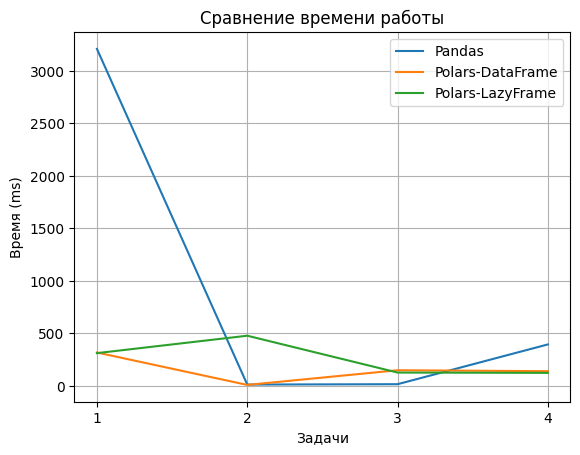

In [75]:
import matplotlib.pyplot as plt
tasks = [1, 2, 3, 4]
pd_times = [head_times[0], category_times[0], words_times[0], year_times[0]]
pl_df_times = [head_times[1], category_times[1], words_times[1], year_times[1]]
pl_lf_times = [head_times[2], category_times[2], words_times[2], year_times[2]]
plt.plot(tasks, pd_times)
plt.plot(tasks, pl_df_times)
plt.plot(tasks, pl_lf_times)
plt.title("Сравнение времени работы")
plt.xlabel("Задачи")
plt.ylabel("Время (ms)")
plt.grid(True)
plt.legend(['Pandas', 'Polars-DataFrame', 'Polars-LazyFrame'])
plt.xticks(tasks)
plt.show()

## Выводы:
1. Чтение и вывод данных происходит горазде быстрее при исползовании Polars.
2. Простые задачи, такие как группировка по столбцу и агрегирование по столбцу на небольшом наборе данных, будет быстрее на обычном Pandas.
3. Если задача требует проебразований столбцов, как в последнем задании, где нужно было определить год по строке, Polars справляется бысрее.
4. Polars LazyFrame, практически во всех задачах на несколько десятком милисекунд быстрее чем Polars DataFrame.